In [1]:
%matplotlib inline
from __future__ import print_function, division
path = "data/baidu/"
#path = "data/state/sample/"
import utils; reload(utils)
from utils import *
from IPython.display import FileLink
import cv2
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.


InternalError: Failed to create session.

In [6]:
with tf.device('/gpu:1'):
    x = tf.placeholder(tf.float32, shape=(None, 20, 64))
    y = LSTM(32)(x)  

In [2]:
train_path = 'data/baidu/image_contest_level_2_processed/'
label_exp_count = load_array('data/baidu/label_exp_num.data')

In [3]:
label_exp_files = []
for i, cnt in enumerate(label_exp_count):
    for c in range(cnt):
        label_exp_files.append('{}-{}-{}.png'.format(i, cnt-c, cnt))

In [4]:
label_path = 'data/baidu/level2_labels.txt'
raw_label_list = []
with open(label_path) as f:
    raw_label_list = f.readlines()
raw_label_list = [x.strip() for x in raw_label_list]
label_exp_num_length= []
exp_labels = []
exp_lens =[]
for line in raw_label_list:
    parts = line.split(' ')
    exprs = parts[0]
    result = parts[1]
    label_exp_num_length.append(len(exprs.split(';')))
    for exp in exprs.split(';'):
        exp_labels.append(exp.decode('utf8'))
        exp_lens.append(len(exp.decode('utf8')))

In [5]:
short_idxs = []
long_idxs = []
cursor = 0
for cnt in label_exp_count:
    for i in range(cnt):
        if i==cnt-1:
            long_idxs.append(cursor+i)
        else: 
            short_idxs.append(cursor+i)
    cursor = cursor + cnt
short_idxs = np.asarray(short_idxs)
long_idxs = np.asarray(long_idxs)

In [6]:
class DataGenator(keras.callbacks.Callback):
    
    def __init__(self, idxs, width, height):
        self.width = width
        self.height = height
        self.idxs = idxs
        self.label_length = max(np.asarray(exp_lens)[self.idxs])

        #mask = np.random.rand(len(self.idxs)) < 0.9
        #self.trn_idxs = self.idxs[mask]
        #self.val_idxs = self.idxs[~mask]
        
        self.token_counts = {}
        for exp in np.asarray(exp_labels)[self.idxs]:
            for c in exp:
                if c in self.token_counts:
                    self.token_counts[c] += 1
                else:
                    self.token_counts[c] = 1
        self.tokens = sorted(self.token_counts.keys()) + ['N']
        self.zero_idx = len(self.tokens)-1
        
        
        self.token_idxs = dict()
        for i,token in enumerate(self.tokens):
            self.token_idxs[token] = i
            
        #所有的label都转化  但不会全部用上  用不上的为空
        self.actual_labels = np.full((len(exp_labels), self.label_length), self.zero_idx)
        for idx in idxs:
            for i, token in enumerate(exp_labels[idx]):
                self.actual_labels[idx][i] = self.token_idxs[token]
            
    def get_batch(self, batch_size, idxs, shuffle=True):
        if shuffle:  
            idxs = np.random.permutation(idxs)
        cur = 0
        idxs_len = len(idxs)
        while True:
            out = []
            next_cur = cur + batch_size
            if next_cur < idxs_len:
                out = idxs[cur: next_cur]
                cur = next_cur
            else:
                exceed = next_cur - idxs_len
                out = idxs[cur: idxs_len]
                if shuffle:  idxs = np.random.permutation(idxs)
                out = np.concatenate([out, idxs[0: exceed]]) 
                cur = exceed
            yield self.fetch_img_by_idxs(out), np.asarray(self.actual_labels)[out]
        
    def fetch_img_by_idxs(self, idxs):
        imgs = []
        for f in np.array(label_exp_files)[idxs]:
            img = cv2.imread(train_path+f)
            img = cv2.resize(img, (self.width, self.height), interpolation = cv2.INTER_LINEAR)
            img = np.transpose(np.asarray(img), (1, 0, 2))
            imgs.append(img)
        return np.array(imgs)
    
    
    def to_pretty_label(self, label):
        l = label.flatten().astype('int')
        s =''
        for token in l:
            if token != self.zero_idx:
                 s = s+self.tokens[token]
        return s    

In [7]:
### 决定使用什么类型的数据
using_idxs = long_idxs
img_label_data_prefix = 'all_long'
data_path = 'data/baidu/all-long-300-45/'

img_w = 300
img_h = 45

img_gen = DataGenator(idxs=using_idxs, width=img_w, height=img_h)

In [8]:
def save_raw_data():
    da = img_gen.get_batch(len(using_idxs), using_idxs, shuffle=False)
    imgs, labels = next(da)
    save_array('data/baidu/{}_imgs.dat'.format(img_label_data_prefix),  imgs)
    save_array('data/baidu/{}_labels.dat'.format(img_label_data_prefix), labels)

def load_raw_data():
    imgs = load_array('data/baidu/{}_imgs.dat'.format(img_label_data_prefix))
    labels = load_array('data/baidu/{}_labels.dat'.format(img_label_data_prefix))
    return (imgs, labels)
    
def save_split_data(x_trn, y_trn, x_val, y_val):

    save_array(data_path+"x_trn", x_trn)
    save_array(data_path+"y_trn", y_trn)


    save_array(data_path+"x_val", x_val)
    save_array(data_path+"y_val", y_val)

def load_split_data():

    x_trn = load_array(data_path+"x_trn")
    y_trn = load_array(data_path+"y_trn")

    x_val = load_array(data_path+"x_val")
    y_val = load_array(data_path+"y_val")
    
    return (x_trn, y_trn, x_val, y_val)

In [101]:
#save_raw_data()
imgs, labels = load_raw_data()

In [123]:
mask = np.random.rand(len(using_idxs)) < 0.9
idxs = np.random.permutation(len(using_idxs))
trn_idxs = idxs[mask]
val_idxs = idxs[~mask]

da = img_gen.get_batch(len(using_idxs), using_idxs, shuffle=False)
imgs, labels = next(da)

x_trn = imgs[trn_idxs]
y_trn = labels[trn_idxs]

x_val = imgs[val_idxs]
y_val = labels[val_idxs]

In [9]:
#save_split_data(x_trn, y_trn, x_val, y_val)
x_trn, y_trn, x_val, y_val = load_split_data()

In [10]:
x_trn.shape, y_trn.shape, x_val.shape, y_val.shape

((90103, 300, 45, 3), (90103, 30), (9897, 300, 45, 3), (9897, 30))

In [11]:
def show_data(x, y):  
    for i in range(len(x)):
        print(img_gen.to_pretty_label(y[i]))
        plots(np.expand_dims(x[i], axis=0))

In [12]:
def gen_label_length(labels):
    label_lengths = np.zeros((len(labels), 1))
    for i in range(len(labels)):
        label_lengths[i] = len(np.where(np.array(labels[i]) != img_gen.zero_idx)[0])
    return label_lengths.astype('uint8')

In [13]:
def map2seq(x):
    return K.reshape(K.permute_dimensions(x, (0, 3, 2, 1)), (x.shape[0], x.shape[-1], -1))

In [14]:
def map2seq_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 4  # only valid for 4D tensors
    return (shape[0], shape[-1], shape[1]*shape[2])

In [15]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

 zoom_range=0.05, shear_range=0.05, channel_shift_range=20,
                             rotation_range=5, height_shift_range=0.03, width_shift_range=0.03

In [53]:
batch_size = 128
da = image.ImageDataGenerator(zoom_range=0.05, shear_range=0.05,
                              channel_shift_range=20, rotation_range=5, 
                              height_shift_range=0.03, width_shift_range=0.03)
x_trn_len = len(x_trn)//batch_size*batch_size
trn_batches = da.flow(x_trn[:x_trn_len], y_trn[:x_trn_len], batch_size=batch_size, shuffle=True)

In [17]:
def trn_gen():
    #减2是因为进入ctc时  已经丢弃了2帧
    input_length = np.zeros([batch_size, 1]) + 71
    while True:
        x, y = next(trn_batches)
        label_length = gen_label_length(y)
        y[np.where(y==img_gen.zero_idx)] = 0
        yield [x, y, input_length, label_length], np.zeros([batch_size])

In [18]:
def val_data():
    size = len(x_val)
    input_length = np.zeros([size, 1]) + 71
    label_length = gen_label_length(y_val)
    return [x_val, y_val, input_length, label_length], np.zeros([size])

In [55]:
batches = trn_gen()
def inspect_trn_data():
    batch = next(batches)[0]
    img = batch[0][0]
    label = batch[1][0]
    il =batch[2][0]
    ll  =batch[3][0]
    print(img.shape)
    plots(np.expand_dims(np.transpose(img, (1,0,2)), axis=0))
    print(label)
    print(img_gen.to_pretty_label(label))
    print(il)
    print(ll)

(300, 45, 3)
[ 0 37  4  8 10  8 13  7  1  3  0 32  5 10  6 12  7 15  4  9  9  8  8  8  1  0  0  0  0  0]
(烧-24271)+(河/40619-33222)(((((
[ 71.]
[25]


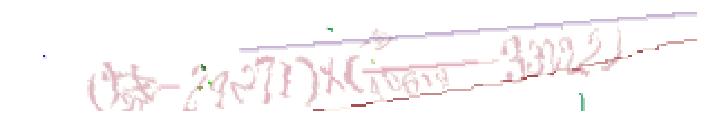

In [61]:
inspect_trn_data()

In [19]:
def is_long_label(label):
    return not(len(np.where(label > 0)[0]) < 10)

In [63]:
def evaluate(base_model, batch_num=None):
    [X_test, y_test, _, label_length], _  = val_data()
    if batch_num is None: batch_num = len(X_test)
    pred = base_model.predict(X_test[:batch_num])
    correct_number = 0
    correct_long_n = 0
    total_long_n = 0
    correct_short_n = 0
    total_short_n = 0
    
    shape = pred[:,2:,:].shape
    out = K.get_value(K.ctc_decode(pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])
    
    for j in range(out.shape[0]):
        
        #-1 是ctc返回的  代表empty
        l = out[j][np.where(out[j] != -1)[0]]
        equal =  label_length[j] == len(l) and np.array_equal(l, y_test[j][:label_length[j][0]])
        
        is_long = is_long_label(y_test[j])
        if is_long:
            total_long_n=total_long_n+1
        else:
            total_short_n=total_short_n+1
        if equal:
            correct_number = correct_number+1
            if is_long:
                correct_long_n=correct_long_n+1
            else:
                correct_short_n=correct_short_n+1
    l = 0
    s = 0
    if total_long_n>0: l=correct_long_n/total_long_n
    if total_short_n>0: s=correct_short_n/total_short_n
    
    return correct_number/batch_num, s, l

In [ ]:
def evaluate2(model, batch_num=10):
    
    [X_test, y_test, _, _], _  = val_data()
    y_pred = base_model.predict(X_test)
    shape = y_pred[:,2:,:].shape
    out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])[:, :4]
    if out.shape[1] == 4:
        batch_acc += ((y_test == out).sum(axis=1) == 4).mean()


In [77]:
[X_test, y_test, _, _], _  = val_data()
pred = base_model.predict(X_test[:10000])
shape = pred[:,2:,:].shape
out = K.get_value(K.ctc_decode(pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])

In [76]:
out.shape

(9968, 36)

In [41]:
K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])

InvalidArgumentError: No OpKernel was registered to support Op 'Inv' with these attrs.  Registered kernels:
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_DOUBLE]
  device='GPU'; T in [DT_HALF]
  device='GPU'; T in [DT_FLOAT]
  device='CPU'; T in [DT_COMPLEX128]
  device='CPU'; T in [DT_COMPLEX64]
  device='CPU'; T in [DT_DOUBLE]
  device='CPU'; T in [DT_HALF]
  device='CPU'; T in [DT_FLOAT]

	 [[Node: moments_20/normalize/divisor = Inv[T=DT_INT32](moments_20/sufficient_statistics/Prod, ^moments_20/sufficient_statistics/mean_ss, ^moments_20/sufficient_statistics/var_ss)]]

Caused by op u'moments_20/normalize/divisor', defined at:
  File "/home/viiv/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/viiv/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-3c89d2fb1285>", line 4, in <module>
    inner = BatchNormalization()(input_data)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 572, in __call__
    self.add_inbound_node(inbound_layers, node_indices, tensor_indices)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 635, in add_inbound_node
    Node.create_node(self, inbound_layers, node_indices, tensor_indices)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 166, in create_node
    output_tensors = to_list(outbound_layer.call(input_tensors[0], mask=input_masks[0]))
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/keras/layers/normalization.py", line 120, in call
    epsilon=self.epsilon)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 1394, in normalize_batch_in_training
    shift=None, name=None, keep_dims=False)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn.py", line 836, in moments
    mean, variance = normalize_moments(counts, m_ss, v_ss, shift, name=name)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn.py", line 787, in normalize_moments
    divisor = math_ops.inv(counts, name="divisor")
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1075, in inv
    result = _op_def_lib.apply_op("Inv", x=x, name=name)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): No OpKernel was registered to support Op 'Inv' with these attrs.  Registered kernels:
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_DOUBLE]
  device='GPU'; T in [DT_HALF]
  device='GPU'; T in [DT_FLOAT]
  device='CPU'; T in [DT_COMPLEX128]
  device='CPU'; T in [DT_COMPLEX64]
  device='CPU'; T in [DT_DOUBLE]
  device='CPU'; T in [DT_HALF]
  device='CPU'; T in [DT_FLOAT]

	 [[Node: moments_20/normalize/divisor = Inv[T=DT_INT32](moments_20/sufficient_statistics/Prod, ^moments_20/sufficient_statistics/mean_ss, ^moments_20/sufficient_statistics/var_ss)]]


In [48]:
(np.ones(shape[0])*shape[1])[0]

68.0

In [68]:
out_best = np.array([1,2])
l = out_best[np.where(out_best != img_gen.zero_idx)[0]]
np.lib.pad(l, ((0, img_gen.label_length - len(l))),  mode='constant', constant_values=0)

array([1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [21]:
from keras.callbacks import *

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc, s, l = evaluate(base_model)
        self.accs.append(acc)
        acc = acc *100
        s = s * 100
        l = l * 100
        print(' acc: {}% long: {}% short: {}%'.format(acc, s, l))
        
        if acc > 95:
            model.save_weights('v{}.wgt'.format(epoch))

evaluator = Evaluate()

In [28]:
ctc_time_lenght = 75
input_shape=(img_gen.width, img_gen.height, 3)
input_data = Input(name='the_input', shape=input_shape, dtype='float32')
inner = BatchNormalization()(input_data)

inner = Convolution2D(64, 3, 3,  activation='relu', border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = Convolution2D(64, 3, 3,  activation='relu', border_mode='same')(inner)
inner = BatchNormalization()(inner)
x = MaxPooling2D()(inner)


inner = Convolution2D(128, 3, 3,  activation='relu', border_mode='same')(x)
inner = BatchNormalization()(inner)
inner = Convolution2D(128, 3, 3,  activation='relu', border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D()(inner)

residual = Convolution2D(128, 1,1, subsample=(2,2))(x)
residual = BatchNormalization()(residual)

x = merge([inner, residual], mode='sum')

inner = Convolution2D(256, 3, 3,  activation='relu', border_mode='same')(x)
inner = BatchNormalization()(inner)
inner = Convolution2D(256, 3, 3,  activation='relu', border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D((1,2))(inner)
inner = ZeroPadding2D(padding={'left_pad':1})(inner)

residual = Convolution2D(256, 1,1, subsample=(1,2))(x)
residual = BatchNormalization()(residual)

x = merge([inner, residual], mode='sum')

inner = Convolution2D(512, 3, 3,  activation='relu', border_mode='same')(x)
inner = BatchNormalization()(inner)
inner = Convolution2D(512, 3, 3,  activation='relu', border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D((1,2))(inner)

#inner = Lambda(map2seq, output_shape=map2seq_output_shape)(inner)
inner = Reshape((ctc_time_lenght, -1))(inner)

inner = Bidirectional(LSTM(256, return_sequences=True, inner_init='identity'), merge_mode='sum')(inner)
inner = BatchNormalization()(inner)

inner = Bidirectional(LSTM(256, return_sequences=True, inner_init='identity'), merge_mode='concat')(inner)
inner = BatchNormalization()(inner)

y_pred = Dense(len(img_gen.tokens), activation='softmax')(inner)

base_model = Model(input=input_data, output=y_pred)

labels = Input(name='the_labels', shape=(img_gen.label_length,), dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64') 

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

model = Model([input_data, labels, input_length, label_length], loss_out)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
the_input (InputLayer)           (None, 300, 45, 3)    0                                            
____________________________________________________________________________________________________
batchnormalization_12 (BatchNorm (None, 300, 45, 3)    12          the_input[0][0]                  
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 300, 45, 64)   1792        batchnormalization_12[0][0]      
____________________________________________________________________________________________________
batchnormalization_13 (BatchNorm (None, 300, 45, 64)   256         convolution2d_11[0][0]           
___________________________________________________________________________________________

In [62]:
input_shape=(img_gen.width, img_gen.height, 3)
input_data = Input(name='the_input_cat', shape=input_shape, dtype='float32')
inner = BatchNormalization()(input_data)

inner = Convolution2D(64, 3, 3)(inner)
inner = BatchNormalization()(inner)
inner = Convolution2D(64, 3, 3)(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D()(inner)

inner = Convolution2D(128, 3, 3)(inner)
inner = BatchNormalization()(inner)
inner = Convolution2D(128, 3, 3,  border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D()(inner)

inner = Convolution2D(256, 3, 3,  border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = Convolution2D(256, 3, 3, border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D((1,2))(inner)

inner = Convolution2D(512, 3, 3, border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = Convolution2D(512, 3, 3, border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D((1,2))(inner)

#inner = Convolution2D(512, 1, 2,  activation='relu')(inner)

ctc_time_lenght = 73
inner = Reshape((ctc_time_lenght, -1))(inner)

inner = Bidirectional(LSTM(256, return_sequences=True, inner_init='identity'), merge_mode='sum')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True, inner_init='identity'), merge_mode='concat')(inner)

inner = BatchNormalization()(inner)


y_pred = Dense(len(img_gen.tokens), activation='softmax')(inner)

base_model = Model(input=input_data, output=y_pred)

labels = Input(name='the_labels', shape=(img_gen.label_length,), dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64') 

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

model = Model([input_data, labels, input_length, label_length], loss_out)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
the_input_cat (InputLayer)       (None, 300, 45, 3)    0                                            
____________________________________________________________________________________________________
batchnormalization_11 (BatchNorm (None, 300, 45, 3)    12          the_input_cat[0][0]              
____________________________________________________________________________________________________
convolution2d_9 (Convolution2D)  (None, 298, 43, 64)   1792        batchnormalization_11[0][0]      
____________________________________________________________________________________________________
batchnormalization_12 (BatchNorm (None, 298, 43, 64)   256         convolution2d_9[0][0]            
___________________________________________________________________________________________

In [23]:
x_trn_len = len(x_trn)//batch_size*batch_size
x_val_len = len(x_val)//batch_size*batch_size

In [24]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/30
89856/89984 [============================>.] - ETA: 1s - loss: 31.4785[14 15 14 10 13  4  0  0 30  5 14 12 11 13  7  9 11  4  9  9  7  9 11  1  2 10 12 15  6  7  1]
[ 0 14 15 13 13  7  2  9 10 14  7 13  1  4  0 18  5  6 14 15 14  8 10  3 11 11 10 12 12  6  1]
[ 0  0 15 13 12 12  9  4 38  5  8 10  7 12  6 13  1  3 13 13  6  8  8  1  2 15 12  8 13  1  8]
[ 0 14  9 11  7 12  3  8 10 15  8  9  1  2  0 32  5 10  9  6 14  6  4 11 12 13 11  7  6  1  1]
 acc: 0.0% long: 0% short: 0.0%
89984/89984 [==============================] - 786s - loss: 31.4393 - val_loss: 4.6032
Epoch 2/30
89984/89984 [==============================] - 786s - loss: 2.5591 - val_loss: 1.6767
Epoch 3/30
 4864/89984 [>.............................] - ETA: 678s - loss: 1.5974

KeyboardInterrupt: 

In [51]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/30
89984/89984 [==============================] - 775s - loss: 1.1983 - val_loss: 1.0255
Epoch 2/30
89984/89984 [==============================] - 778s - loss: 0.8268 - val_loss: 0.9390
Epoch 3/30
89984/89984 [==============================] - 779s - loss: 0.6024 - val_loss: 0.8854
Epoch 4/30
12288/89984 [===>..........................] - ETA: 613s - loss: 0.5481

KeyboardInterrupt: 

In [64]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/30
89984/89984 [==============================] - 784s - loss: 60.4604 - val_loss: 35.9978
Epoch 2/30
89984/89984 [==============================] - 779s - loss: 11.7352 - val_loss: 3.7134
Epoch 3/30
89984/89984 [==============================] - 781s - loss: 5.0956 - val_loss: 3.2039
Epoch 4/30
89984/89984 [==============================] - 780s - loss: 3.5221 - val_loss: 1.6335
Epoch 5/30
89984/89984 [==============================] - 778s - loss: 2.8496 - val_loss: 1.2290
Epoch 6/30
89984/89984 [==============================] - 779s - loss: 2.4471 - val_loss: 1.2697
Epoch 7/30
89984/89984 [==============================] - 778s - loss: 2.1788 - val_loss: 0.8673
Epoch 8/30
89984/89984 [==============================] - 781s - loss: 1.9713 - val_loss: 0.8966
Epoch 9/30
89984/89984 [==============================] - 779s - loss: 1.8470 - val_loss: 0.7030
Epoch 10/30
89984/89984 [==============================] - 780s - loss: 1.7064 - val_loss: 0.7733
Epoch 11/30
89984/89984 [=

In [65]:
model.optimizer.lr = 0.0001
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history2 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/30
89984/89984 [==============================] - 854s - loss: 0.9307 - val_loss: 0.3982
Epoch 2/30
89984/89984 [==============================] - 849s - loss: 0.9010 - val_loss: 0.3079
Epoch 3/30
89984/89984 [==============================] - 851s - loss: 0.9063 - val_loss: 0.3064
Epoch 4/30
89984/89984 [==============================] - 852s - loss: 0.8896 - val_loss: 0.3362
Epoch 5/30
14720/89984 [===>..........................] - ETA: 656s - loss: 0.9058

KeyboardInterrupt: 

In [63]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=1, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/1
89856/89920 [============================>.] - ETA: 0s - loss: 1.7546 acc: 62.771902%
 short: 0.000000%
 l: 62.771902%
89920/89920 [==============================] - 928s - loss: 1.7543 - val_loss: 1.7435


In [101]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=20, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)


Epoch 1/20
89920/89984 [============================>.] - ETA: 0s - loss: 13.4784 acc: 55.311905%
 short: 0.000000%
 l: 55.311905%
89984/89984 [==============================] - 1140s - loss: 13.4700 - val_loss: 2.0453
Epoch 2/20
89920/89984 [============================>.] - ETA: 0s - loss: 1.2172 acc: 68.509062%
 short: 0.000000%
 l: 68.509062%
89984/89984 [==============================] - 1127s - loss: 1.2171 - val_loss: 1.3251
Epoch 3/20
89920/89984 [============================>.] - ETA: 0s - loss: 0.7752 acc: 80.744968%
 short: 0.000000%
 l: 80.744968%
89984/89984 [==============================] - 1138s - loss: 0.7752 - val_loss: 0.7840
Epoch 4/20
89920/89984 [============================>.] - ETA: 0s - loss: 0.5837[ 0 13  6 13 11 14  2 13 10  7 14 13  1  2  0 19  5 15 13  8  9 15  3 10 11  6 15 10 11  1  1]
 acc: 80.915190%
 short: 0.000000%
 l: 80.915190%
89984/89984 [==============================] - 1128s - loss: 0.5837 - val_loss: 0.7762
Epoch 5/20
89920/89984 [===========

KeyboardInterrupt: 

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=20, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

model.optimizer.lr=0.0001
history2 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=20, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/20
89920/89984 [============================>.] - ETA: 0s - loss: 13.9007 acc: 72.233904%
 short: 0.000000%
 l: 72.233904%
89984/89984 [==============================] - 1102s - loss: 13.8911 - val_loss: 1.1992
Epoch 2/20
89920/89984 [============================>.] - ETA: 0s - loss: 0.6437 acc: 87.513768%
 short: 0.000000%
 l: 87.513768%
89984/89984 [==============================] - 1092s - loss: 0.6434 - val_loss: 0.5349
Epoch 3/20
89920/89984 [============================>.] - ETA: 0s - loss: 0.3808 acc: 89.696606%
 short: 0.000000%
 l: 89.696606%
89984/89984 [==============================] - 1094s - loss: 0.3807 - val_loss: 0.4391
Epoch 4/20
89920/89984 [============================>.] - ETA: 0s - loss: 0.2809 acc: 91.989586%
 short: 0.000000%
 l: 91.989586%
89984/89984 [==============================] - 1092s - loss: 0.2809 - val_loss: 0.3645
Epoch 5/20
89920/89984 [============================>.] - ETA: 0s - loss: 0.2190 acc: 89.015720%
 short: 0.000000%
 l: 89.015720%


KeyboardInterrupt: 

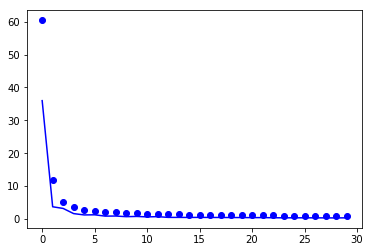

In [66]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')

plt.show()


In [ ]:
model.optimizer.lr=0.00001
history3 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=20, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/20
215488/215552 [============================>.] - ETA: 0s - loss: 2.5804[ 0 39  5 13 13  7 12  9  2  0  0  8  7  7 14 11  2  8  6 10 11 15  1  1  2 11 14  6 11 11  1]
[ 0 14 10 13 15  8  2  0  0 10  8 14  9 14  4 39  5 11  9  6  8  6  1  1  4  1 14  9 10 10  1]
 acc: 69.959228%
 short: 91.786268%
 l: 33.765363%
215552/215552 [==============================] - 824s - loss: 2.5802 - val_loss: 1.9581
Epoch 2/20
215488/215552 [============================>.] - ETA: 0s - loss: 3.6731[ 0 19  5 13 13  7 12 15  2  0  0  8  7  7 14 11  2  8  6 10 11 15  1  1  2 11 14  6 11 11  1]
[ 0  9 11 10 13  8  2  7 15 14  7 15  1  4  0  9 13 14 14 13  1  2 25  5 13  7 10  6 13 15  1]
[ 0  9  7  7 12  6  6  3  0 27  5 13  7  6  6 12  2 11  6  7 14  6  1  1  4 12 10  7 13  8  1]
 acc: 71.535455%
 short: 90.802507%
 l: 39.586592%
215552/215552 [==============================] - 825s - loss: 3.6725 - val_loss: 1.6757
Epoch 3/20
215488/215552 [============================>.] - ETA: 0s - loss: 2.2219 

KeyboardInterrupt: 

In [26]:
def show_result(base_model, batch_num=None):
    [X_test, y_test, _, _], _  = val_data()
    if batch_num is None: batch_num = len(X_test)
    out = base_model.predict(X_test[:batch_num])
    correct_number = 0
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = np.array([k for k, g in itertools.groupby(out_best)])
        l = out_best[np.where(out_best != img_gen.zero_idx)[0]]
        
        print(img_gen.to_pretty_label(l))
        plots(np.expand_dims(np.transpose(X_test[j], (1,0,2)), axis=0))
    

In [48]:
def show_wrong_result(base_model, batch_num=None):
    [X_test, y_test, _, label_length], _  = val_data()
    if batch_num is None: batch_num = len(X_test)
    pred = base_model.predict(X_test[:batch_num])
    correct_number = 0
    
    shape = pred[:,2:,:].shape
    out = K.get_value(K.ctc_decode(pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])
    
    for j in range(out.shape[0]):
        l = out[j][np.where(out[j] != -1)[0]]
        
        if label_length[j] != len(l) or not np.array_equal(l, y_test[j][:label_length[j][0]]):
            print(u'{}  {}'.format(img_gen.to_pretty_label(l), img_gen.to_pretty_label(y_test[j])))
            plots(np.expand_dims(np.transpose(X_test[j], (1,0,2)), axis=0))
    

柳=29839
柳=6075
91656+(82642-(回/46950+8842))
锁=67574
塘*(复/85814-77494-43109)
柳-(65454*(奔/26836-7834))
水=22871
锁=35473
深=44448
((81984+27327)-烧)*奔/43062


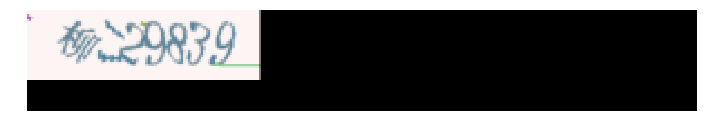

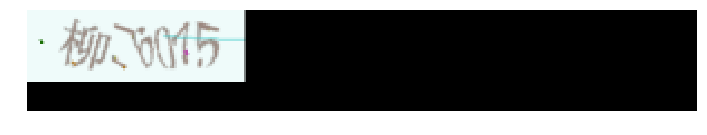

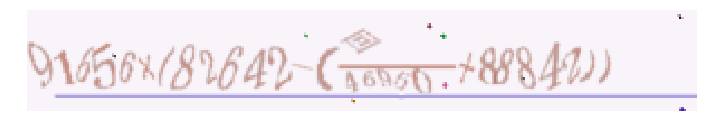

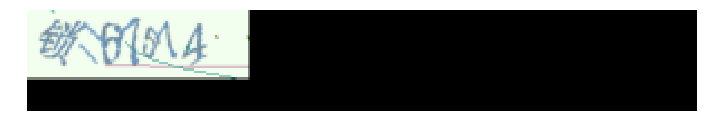

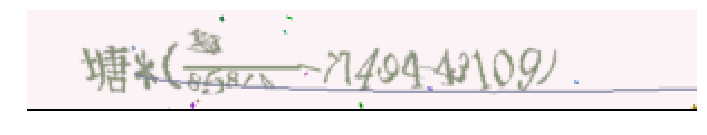

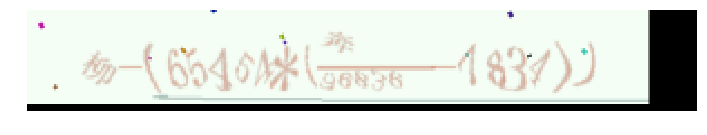

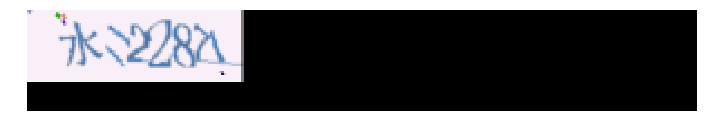

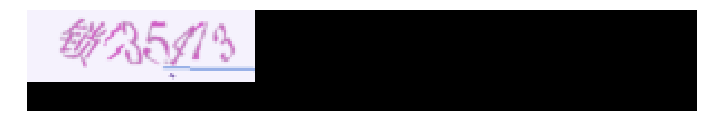

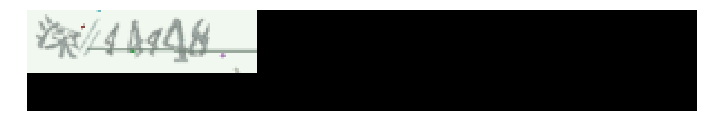

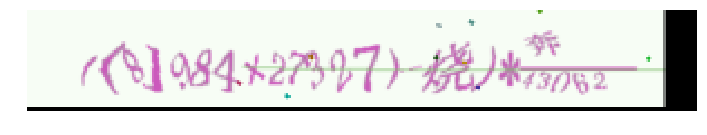

In [70]:
show_result(base_model, 10)

深*(83446+(水/71161+97951))  深*(83446+(水/71151+97951))
(70082+94717)-圳-上/76741  (70082+94517)-圳-之/36544
71462-(1645-(上/90166*68797))  71462-(1645-(上/90106*68797))
(60941+(44185+43850))+河/86673  (60941+(44185+43850))+河/96673
71726+深-(72299*海/80132)  71726+深-(72299*流/80132)
13590+(71380-(河/12218+塘))  13590+(71380-(河/12278+塘))
82485+14108+水/40556+53670  82485+14108+水/40596+53670
(5200+天/93468*锁)+27902  (5200+天/93469*锁)+27902
((到/22566-87434)-964)-86950  ((到/22506-87434)-964)-86950
((烟+30049)+95451)*到/58212  ((烟+30049)+95451)*到/59212
79874-62487+柳+河/80268  79874-62487+柳+河/80368


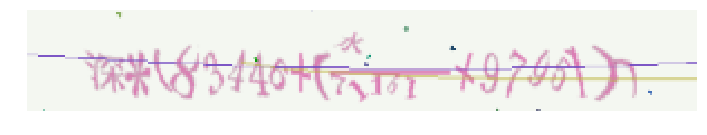

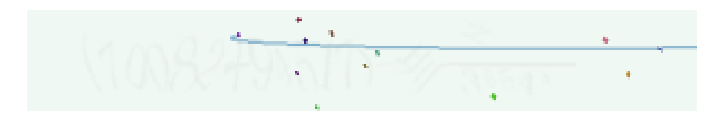

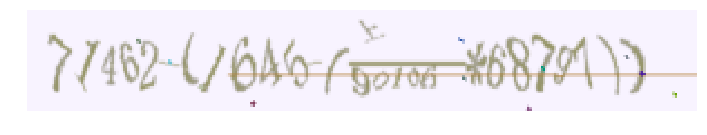

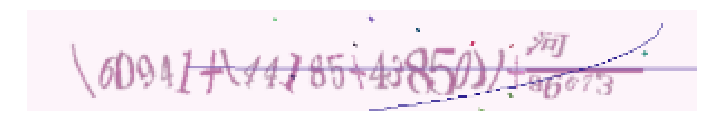

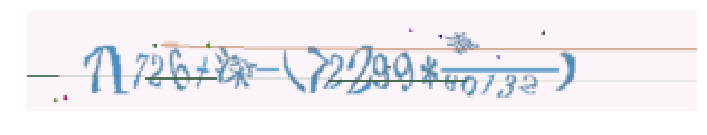

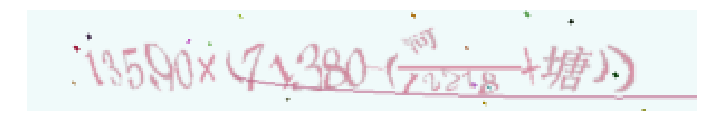

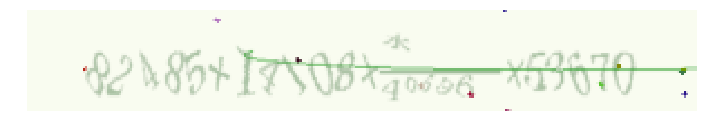

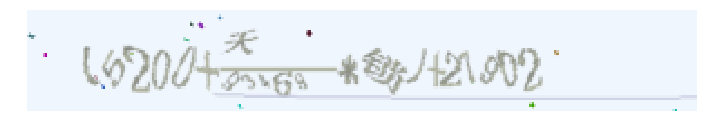

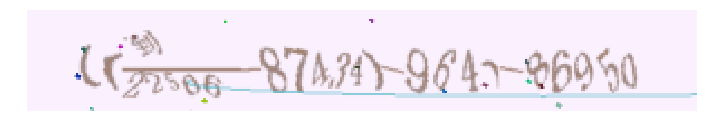

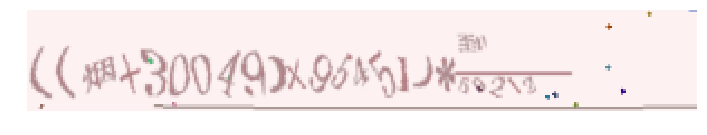

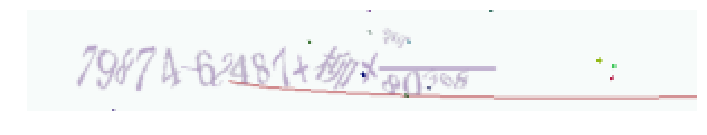

In [68]:
show_wrong_result(base_model, 100)

In [61]:
model.save_weights('l2_first_54.wgt')

In [92]:
model.load_weights('l2_first_54.wgt')

In [95]:
model.save('l2_first_54.h5')

In [59]:
model.save_weights('xxx.wgt')

In [22]:
model.load_weights('xxx.wgt')

In [ ]:
model